# Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = "/content/drive/MyDrive/MRI Images/Training"
test_dir  = "/content/drive/MyDrive/MRI Images/Testing"

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

N_CLASSES = len(train_generator.class_indices)
print("Classes:", train_generator.class_indices)

Found 5712 images belonging to 4 classes.
Found 1321 images belonging to 4 classes.
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base.trainable = False  # freeze base model

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(N_CLASSES, activation="softmax")(x)

model = models.Model(inputs=base.input, outputs=out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[es, rlr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 2006s 11s/step - accuracy: 0.7297 - loss: 0.6678 - val_accuracy: 0.8403 - val_loss: 0.3821 - learning_rate: 0.0010
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 504ms/step - accuracy: 0.8730 - loss: 0.3365 - val_accuracy: 0.8766 - val_loss: 0.3141 - learning_rate: 0.0010
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 533ms/step - accuracy: 0.8813 - loss: 0.3082 - val_accuracy: 0.8736 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 531ms/step - accuracy: 0.9014 - loss: 0.2545 - val_accuracy: 0.8577 - val_loss: 0.3351 - learning_rate: 0.0010
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 495ms/step - accuracy: 0.9138 - loss: 0.2342 - val_accuracy: 0.9107 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 518ms/step - accuracy: 0.9191 - loss: 0.2202 - val_accuracy: 0.8978 - val_loss: 0.2827 - learning_rate: 0.0010
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 496ms/step - accuracy: 0.9

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━

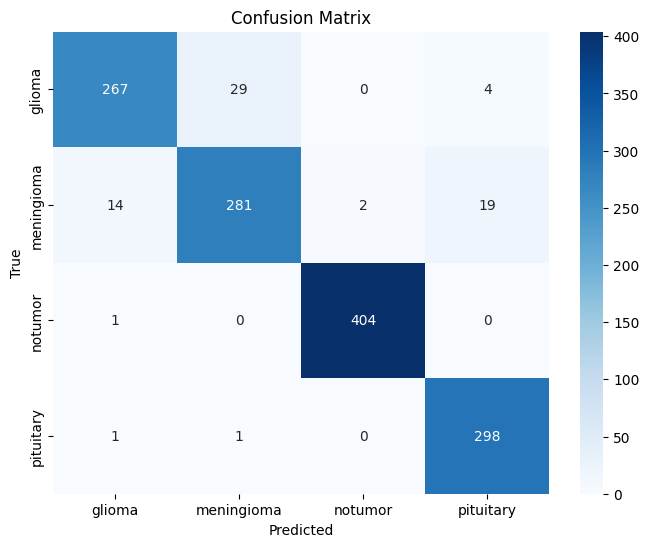


Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.89      0.92       300
  meningioma       0.90      0.89      0.90       316
     notumor       1.00      1.00      1.00       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.95      1321
   macro avg       0.94      0.94      0.94      1321
weighted avg       0.95      0.95      0.95      1321



In [ ]:
y_true = []
y_pred = []

for images, labels in test_generator:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= test_generator.samples:
        break

cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
def get_img_array(img_path, size=(224, 224)):
    """Load and preprocess image"""
    img = tf.keras.utils.load_img(img_path, target_size=size)
    arr = tf.keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()
def display_gradcam(img_path, model, last_conv_layer_name="top_conv", alpha=0.4):
    img_array = get_img_array(img_path)
    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])
    labels = list(test_generator.class_indices.keys())
    print(f"Predicted class: {labels[pred_class]} ({preds[0][pred_class]:.2f})")

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1])).numpy()

    plt.figure(figsize=(6,6))
    plt.subplot(1,2,1)
    plt.imshow(img.astype("uint8"))
    plt.title("Original Image")

    plt.subplot(1,2,2)
    plt.imshow(img.astype("uint8"))
    plt.imshow(heatmap, cmap="jet", alpha=alpha)
    plt.title("Grad-CAM")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predicted class: meningioma (0.94)


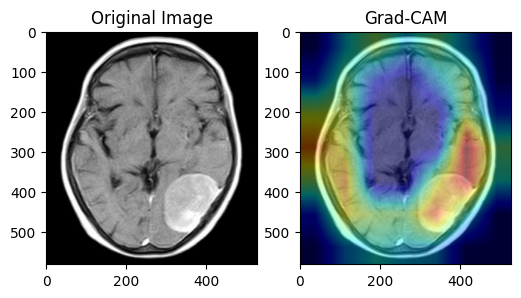

In [ ]:
sample_img_path = test_dir + "/meningioma/Te-meTr_0004.jpg" # <- replace with a real path
display_gradcam(sample_img_path, model)